# Collaborative Filtering

Collaborative filtering methods build a model based on users past behavior (items previously purchased, movies viewed and rated, etc) and use decisions made by current and other users. This model is then used to predict items (or ratings for items) that the user may be interested in.

Content based movie recommendation system has certain disadvantages:
- It is not capable of capturing tastes of users 
- Cannot provide recommendations across genres.
- Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

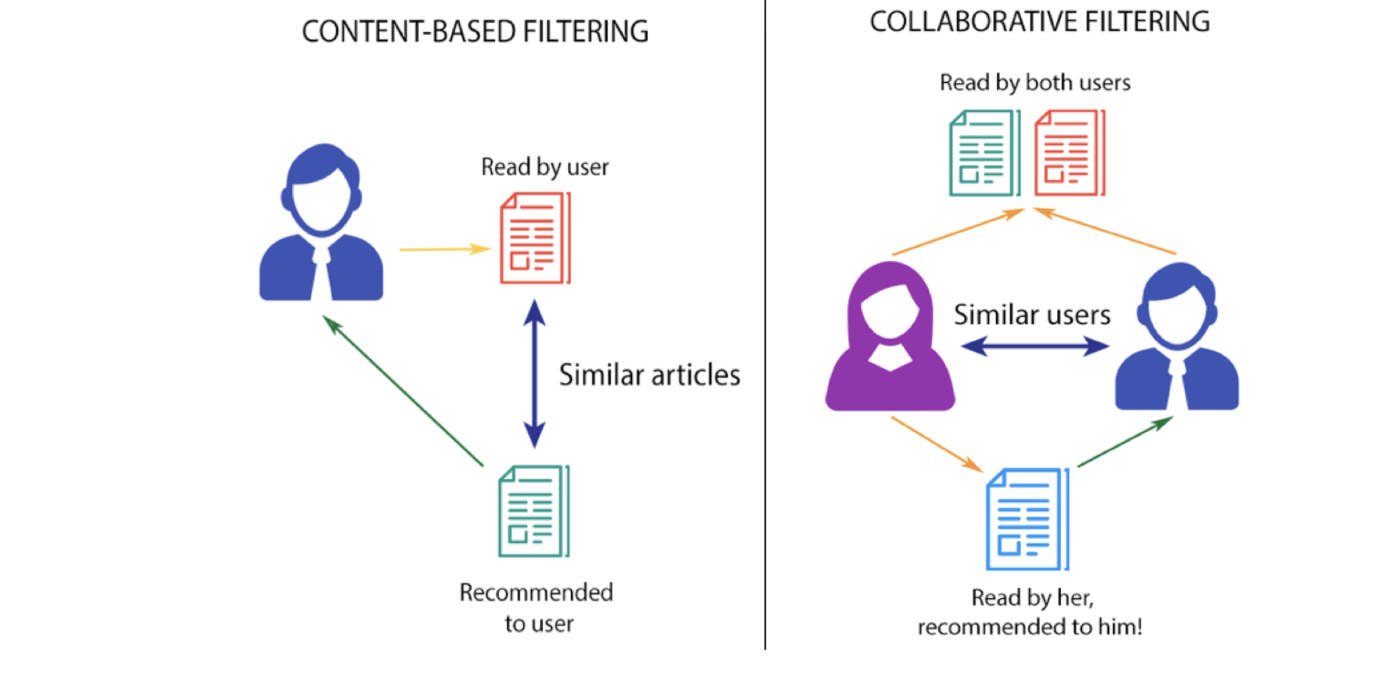

## Loading Libraries.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

We will use the famous 100k MovieLens dataset.

In [3]:
init_movies = pd.read_csv('movies.csv',usecols=['movieId', 'title'], dtype={'movieId':'int32', 'title':'str'})
init_ratings = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'],
                           dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

In [4]:
init_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
init_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


- We will join this two datasets

In [6]:
movie_ratings = pd.merge(init_movies, init_ratings, on = 'movieId')

In [7]:
movie_ratings.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [8]:
movie_ratings.isna().sum()

movieId    0
title      0
userId     0
rating     0
dtype: int64

In [9]:
movie_ratings['rating'].isna().sum()

0

- There is `No null values` in the ratings column.

In [60]:
print(f'Total number of ratings: {movie_ratings.shape[0]}')
print(f"Total number of Movies:{len(np.unique(movie_ratings['movieId']))}")
print(f"Total number of Users:{len(np.unique(movie_ratings['userId']))}")

Total number of ratings: 100836
Total number of Movies:9724
Total number of Users:610


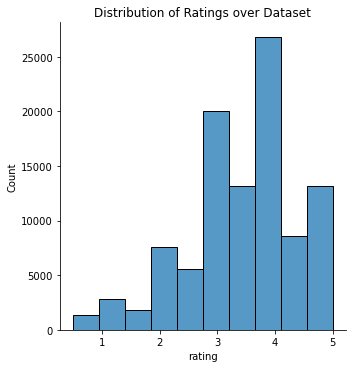

In [127]:
sns.displot(movie_ratings, x = 'rating', bins = 10)
plt.title('Distribution of Ratings over Dataset')
plt.show()

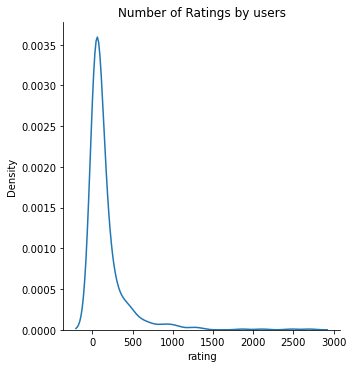

- Most of the users have rated 500 movies or less.

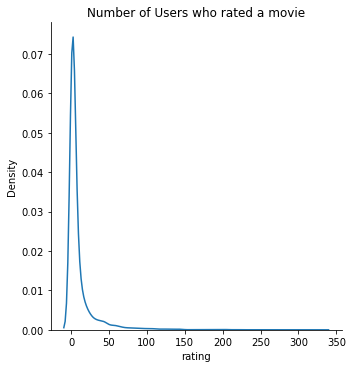

In [140]:
sns.displot(movie_ratings.groupby(by ='movieId')['rating'].count().sort_values(ascending = False),  kind ='kde')
plt.title('Number of Users who rated a movie')
plt.show()

- There are some movies which are rated by many and most of the movies have got some hundreds of ratings.

### Finding out Users and Movies whose Rating Matters.

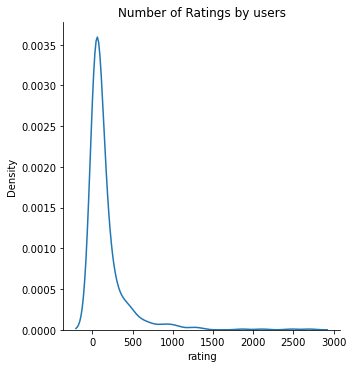

In [160]:
sns.displot(movie_ratings.groupby(by ='userId')['rating'].count().sort_values(ascending = False),  kind ='kde')
plt.title('Number of Ratings by users')
plt.show()

In [10]:
rating_byuser = movie_ratings.groupby('userId')['rating'].count()

In [11]:
rating_byuser.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

- Avarage number of movies voted by a user: 165
- Lowest number of movies rated by a User: 20
- Maximum number of movies voted by a User : 2698
- Maximum or Threshold number of Ratings a user should have voted to be considered: 100

In [12]:
rating_bymovie = movie_ratings.groupby('movieId')['userId'].count()

In [13]:
rating_bymovie.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: userId, dtype: float64

- Avarage number of ratings that a movie received: 10
- Lowest number of ratings that a movie received: 1
- Maximum number of ratings that a movie received: 329
- Threshold number of Ratings that a movie should have received to be considered: 50

In [14]:
rating_bymovie[rating_bymovie > 50].count()

436

In [15]:
final_df = movie_ratings[movie_ratings['userId'].isin(rating_byuser[rating_byuser >= 100].index)].reset_index(drop = True)

In [16]:
movieratings_final = final_df[final_df['movieId'].
              isin(rating_bymovie[rating_bymovie > 50].index)].reset_index(drop = True)

In [17]:
print(f'Total number of Columns in the Initial Dataset: {movie_ratings.shape[0]}')
print(f'Total number of Columns in the Final Dataset after adding threshold: {movieratings_final.shape[0]}')

Total number of Columns in the Initial Dataset: 100836
Total number of Columns in the Final Dataset after adding threshold: 30832


In [18]:
movieratings_final['movieId'].drop_duplicates(inplace= True)

In [19]:
movieratings_final.shape

(30832, 4)

## Collaborative Filtering using K- Nearest Neighbours(k-NN)

We convert our table to a 2D matrix, and fill the missing values with zeros. We will then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [20]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [21]:
movieratings_pivot = movieratings_final.pivot(index = 'title', columns = 'userId', values = 'rating').fillna(0)

In [33]:
movieratings_pivot

userId,1,4,6,7,10,15,17,18,19,20,...,600,601,602,603,604,605,606,607,608,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,3.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,3.0,0.0,...,4.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,5.0
300 (2007),0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-Men: The Last Stand (2006),0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0
X2: X-Men United (2003),0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
Young Frankenstein (1974),5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,4.0,0.0,0.0,5.0,0.0,0.0,3.5,0.0,0.0,0.0


In [23]:
# Creating a csr sparse matrix.
movieratings_matrix = csr_matrix(movieratings_pivot.values)

In [24]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movieratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [61]:
query_index = np.random.choice(movieratings_pivot.shape[0])
print(movieratings_pivot.index[query_index])
distances, indices = model_knn.kneighbors(movieratings_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)

Dances with Wolves (1990)


In [26]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommended movies, similar to {movieratings_pivot.index[query_index]}:\n')
    else:
        print(f"{i}: {movieratings_pivot.index[indices.flatten()[i]]} with distance of {distances.flatten()[i]}:")

Recommended movies, similar to Shining, The (1980):

1: Fight Club (1999) with distance of 0.3508768081665039:
2: Pulp Fiction (1994) with distance of 0.35677123069763184:
3: Goodfellas (1990) with distance of 0.36859583854675293:
4: Fargo (1996) with distance of 0.3734878897666931:
5: Sixth Sense, The (1999) with distance of 0.3739294409751892:
6: Silence of the Lambs, The (1991) with distance of 0.37639540433883667:
7: Reservoir Dogs (1992) with distance of 0.37671738862991333:
8: Alien (1979) with distance of 0.37845611572265625:
9: American Beauty (1999) with distance of 0.3859296441078186:
10: Godfather, The (1972) with distance of 0.39063698053359985:


In [27]:
import pickle

In [28]:
pickle.dump(model_knn, open('model_knn.pkl', 'wb'))

In [29]:
movieratings_pivot.to_pickle('movieratings_pivot.pkl')

For further reference:
- https://towardsdatascience.com/how-you-can-build-simple-recommender-systems-with-surprise-b0d32a8e4802
- https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
- https://analyticsindiamag.com/a-guide-to-surprise-python-tool-for-recommender-systems/
- https://surprise.readthedocs.io/en/stable/getting_started.html#
    